In [2]:
import pandas as pd #needed to import dataset

# Load a CSV file
full = pd.read_csv("C:/Users/annaw/Desktop/DataScience/Datasets/full_dataset.csv",
    dtype={91: str})



In [15]:
#Building a binary classifier to predict whether an avalanche will occur (1) or not (0)
#Based on environmental features - for example: snow, temperature, water, radiation,...

In [3]:
# Basic info
print(full.info())  # data types, missing values
print(full.head())  # first few rows
print(full.describe())  # statistics for numerical columns

# Check for missing values
print(full.isnull().sum())

# drop columns with >20% missing
full_clean = full.dropna(thresh=len(full)*0.8, axis=1)  
print(full_clean.info())  # data types, missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11362 entries, 0 to 11361
Data columns (total 95 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datum                  11362 non-null  object 
 1   station_code           11362 non-null  object 
 2   aspect                 11362 non-null  float64
 3   elevation              11362 non-null  float64
 4   avalancheDay1          11362 non-null  int64  
 5   max_height             11362 non-null  float64
 6   TSS_mod                11362 non-null  float64
 7   prop_base_3_diff       11362 non-null  float64
 8   ILWR_daily             11362 non-null  float64
 9   RH_daily               11362 non-null  float64
 10  ISWR_diff_daily        11362 non-null  float64
 11  prop_base_1_diff       11362 non-null  float64
 12  prop_wet_2_diff        11362 non-null  float64
 13  prop_wet_3_diff        11362 non-null  float64
 14  max_height_3_diff      11362 non-null  float64
 15  lo

In [4]:
###### Random forest to find important features

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import plot_confusion_matrix,
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from matplotlib.pylab import rcParams
from sklearn.preprocessing import StandardScaler


In [7]:
# Drop non-numeric columns and missing data
full_clean = full.dropna(thresh=len(full)*0.8, axis=1)
full_clean = full_clean.dropna()  # drop rows with missing values
#Question - OK??

# Encode categorical variables - models can only use numbers not text
categorical_cols = full_clean.select_dtypes(include='object').columns
full_encoded = pd.get_dummies(full_clean, columns=categorical_cols, drop_first=True)

# Split features and target
X = full_encoded.drop(columns=["avalancheDay1"])   # all columns except the target
y = full_encoded["avalancheDay1"]  # avalanche label: 1 = avalanche, 0 = no avalanche

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Train Decision Tree Classifier
clf_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

Decision Tree Evaluation:
[[1923    0]
 [ 124   12]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1923
           1       1.00      0.09      0.16       136

    accuracy                           0.94      2059
   macro avg       0.97      0.54      0.57      2059
weighted avg       0.94      0.94      0.92      2059



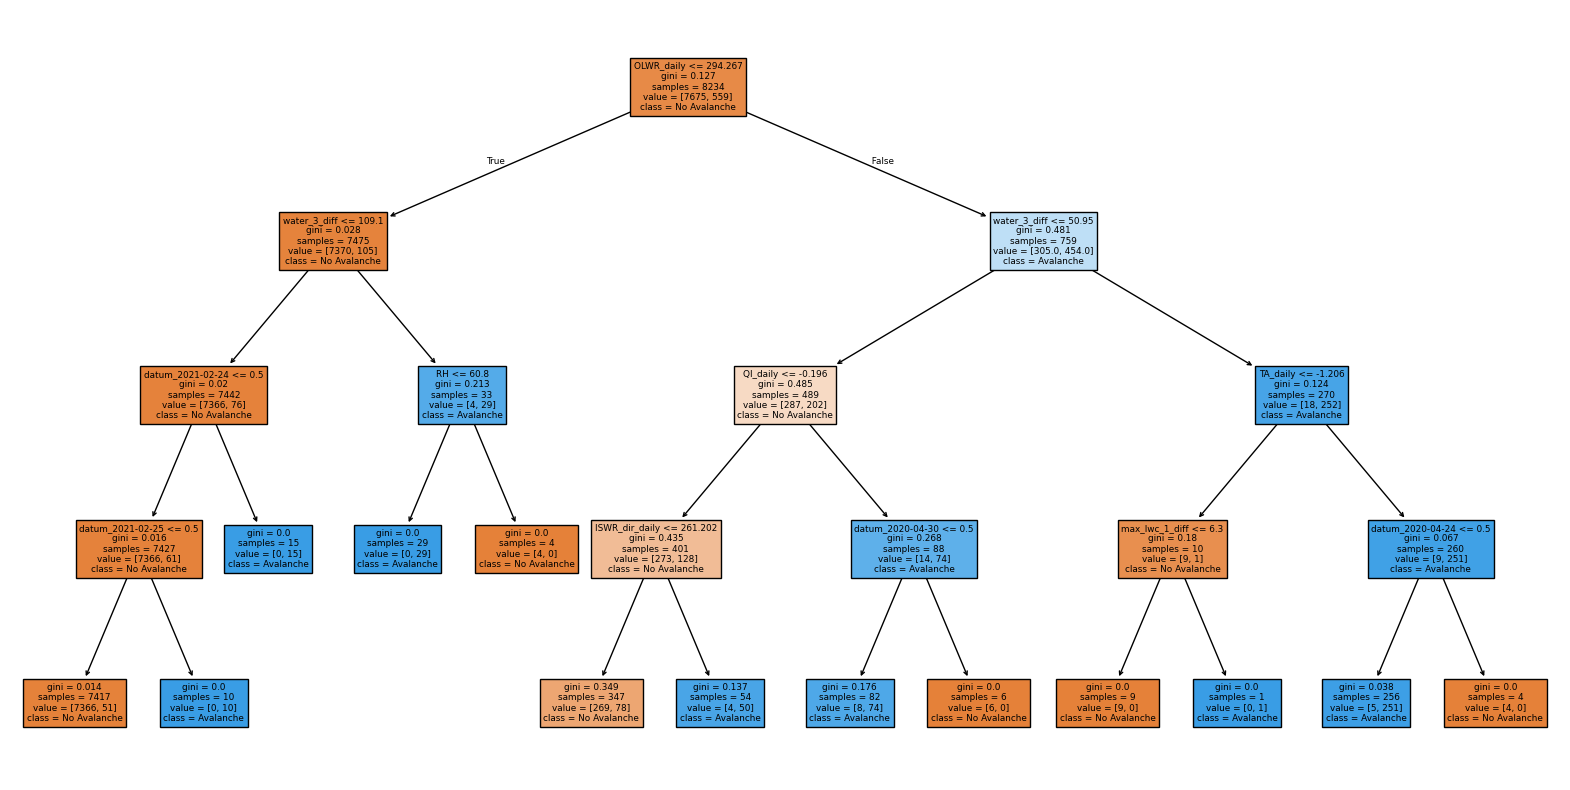

In [9]:
# Predict and evaluate
y_pred_tree = clf_tree.predict(X_test_scaled) #predicts labels on the test set given the decision tree
print("Decision Tree Evaluation:")
print(confusion_matrix(y_test, y_pred_tree)) # confusion matrix
print(classification_report(y_test, y_pred_tree)) # precision, recall, f1, support

# Plot tree
plt.figure(figsize=(20, 10))
plot_tree(clf_tree, feature_names=X.columns, class_names=['No Avalanche', 'Avalanche'], filled=True)
plt.show()

#[[1923    0]   → True Negatives / False Positives
#[ 124   12]]  → False Negatives / True Positives

#Accuracy is really high (94%)
#BUT: Avalanche recall is very low --> only 9% of avalanche days were correctly identified :/

# plotted tree shows how feature splits lead to predictions

# PROBLEM
# The model is heavily biased toward the majority class (no avalanche)
# Only 12 out of 136 avalanche days were predicted correctly == miss 91% of avalanche events!!!!!


# Avalanches are rare --> strong class imbalance
# Decision Trees (especially shallow ones like max_depth=4) tend to underfit minority classes
# The model plays it save by mostly predicting NO avalanche days

# Could do: “If snow height ≤ x and radiation ≥ y, then we predict no avalanche.”

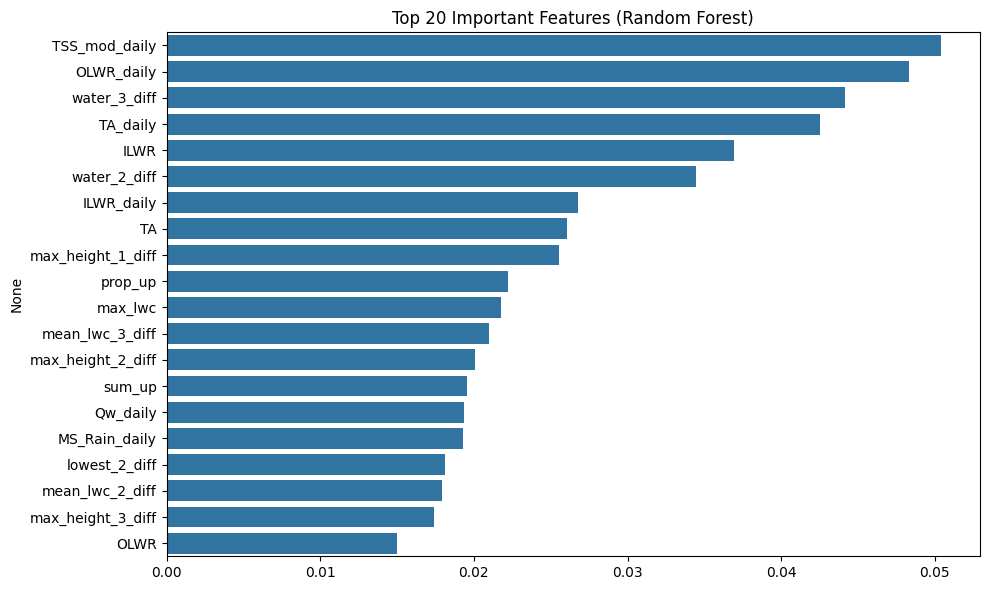

In [19]:
# Train Random Forest with 100 trees
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_scaled, y_train)

# Feature importance
importances = clf_rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X.columns[indices][:20]

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:20], y=top_features)
plt.title("Top 20 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

# Feature: Meaning / Why It Matters
# TSS_mod_daily: Snow surface temperature → affects melt/refreeze cycles
# OLWR_daily: Outgoing longwave radiation → linked to energy balance
# water_3_diff: Water content in layer 3 (deep snow) → potential instability
# TA_daily: Air temperature → critical for thawing/freezing
# ILWR / ILWR_daily: Incoming longwave radiation → heat exchange

#These features make sense in avalanche science 
#temperature, water content, and radiation balance are known triggers or indicators of unstable snowpack conditions

#!!
# Non-causal: These variables correlate with avalanche risk — they do not necessarily cause avalanches

Random Forest Evaluation:
[[1920    3]
 [  19  117]]
              precision    recall  f1-score   support

No Avalanche       0.99      1.00      0.99      1923
   Avalanche       0.97      0.86      0.91       136

    accuracy                           0.99      2059
   macro avg       0.98      0.93      0.95      2059
weighted avg       0.99      0.99      0.99      2059



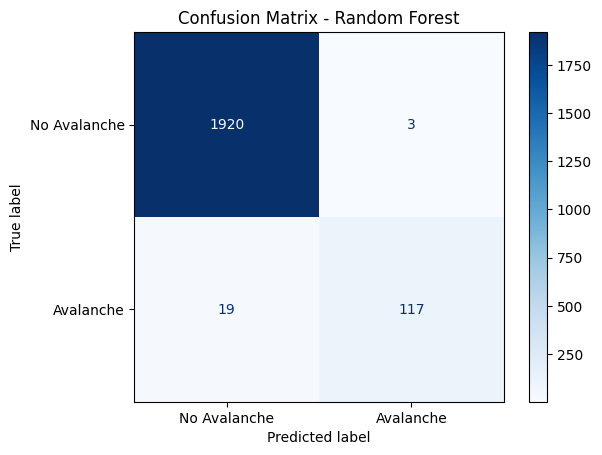

Random Forest Accuracy: 0.99


In [21]:
# Predict with Random Forest
#Predicts avalanche (1) or no avalanche (0) on the test set
y_pred_rf = clf_rf.predict(X_test_scaled)

# Evaluate Random Forest
print("Random Forest Evaluation:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)
print(classification_report(y_test, y_pred_rf, target_names=["No Avalanche", "Avalanche"]))

#True Negatives (TN): 1920 → Correctly predicted no avalanche
#False Positives (FP): 3 → Predicted avalanche, but none happened
#False Negatives (FN): 19 → Predicted no avalanche, but avalanche happened (NOT GOOD)
#True Positives (TP): 117 → Correctly predicted avalanche 

# Confusion Matrix Display
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Avalanche", "Avalanche"])
disp_rf.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

#Precision (Avalanche): 0.97  
#97% of predicted avalanches were real.

# Recall (Avalanche): 0.86
# 86% of actual avalanches were detected (only 14% missed).

# F1 Score (Avalanche): 0.91
# Very strong harmonic mean of precision & recall.

# Overall Accuracy: 0.99 (amazing — but secondary to look at for risk prediction)

# Accuracy
accuracy_rf = clf_rf.score(X_test_scaled, y_test)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

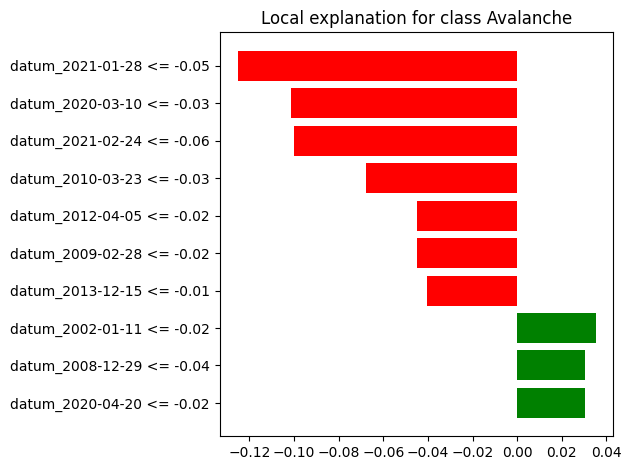

In [12]:
#LIME = shows what pushed the prediction toward "Avalanche" or "No Avalanche" for a specific day

import lime
import lime.lime_tabular

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns,
    class_names=['No Avalanche', 'Avalanche'],
    mode='classification'
)

# Choose a test instance to explain (e.g. the 5th test sample)
# LIME only explains one data point at a time
# X_test_scaled[i] == one specific test sample (a day with certain snow/weather values)

# runs LIME to explain why it was classified as either "Avalanche" or "No Avalanche"
i = 5
exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)


# Show explanation in notebook or plot
exp.show_in_notebook(show_table=True)

# or plot it
# Local feature importance plot.
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()



=== Explanation for Test Sample #0 ===

Feature values for this day:
aspect                      1.0
elevation                2730.0
max_height                47.93
TSS_mod                  -6.265
prop_base_3_diff            0.0
                          ...  
Dataset_Data3_nowcast      True
month_December            False
month_February            False
month_January              True
month_March               False
Name: 11157, Length: 488, dtype: object
True label: No Avalanche


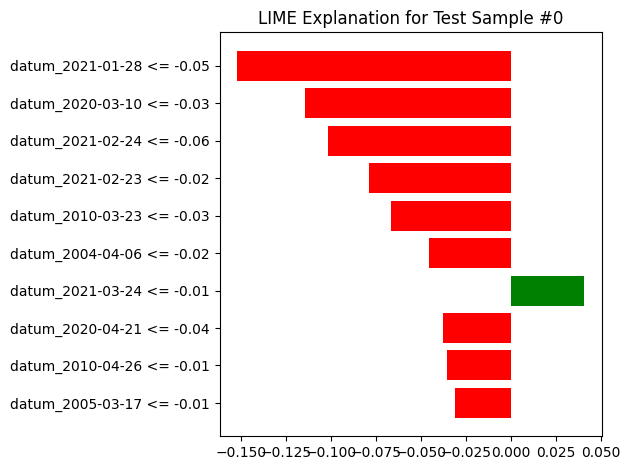


=== Explanation for Test Sample #5 ===

Feature values for this day:
aspect                      4.0
elevation                2394.0
max_height               224.16
TSS_mod                     0.0
prop_base_3_diff            0.0
                          ...  
Dataset_Data3_nowcast     False
month_December            False
month_February            False
month_January             False
month_March                True
Name: 7707, Length: 488, dtype: object
True label: No Avalanche


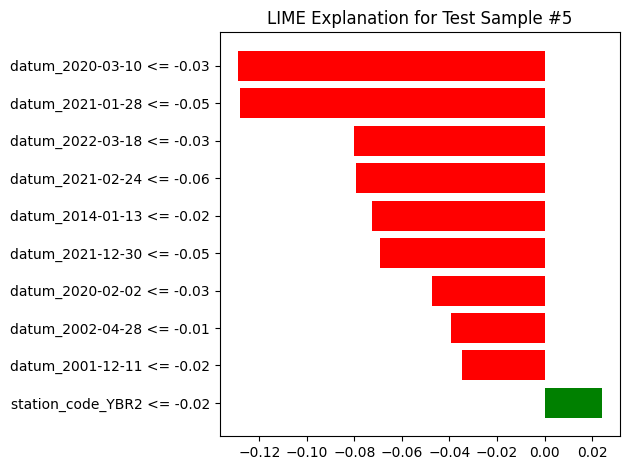


=== Explanation for Test Sample #25 ===

Feature values for this day:
aspect                      1.0
elevation                2439.0
max_height               165.62
TSS_mod                 -16.629
prop_base_3_diff            0.0
                          ...  
Dataset_Data3_nowcast     False
month_December            False
month_February            False
month_January              True
month_March               False
Name: 6507, Length: 488, dtype: object
True label: No Avalanche


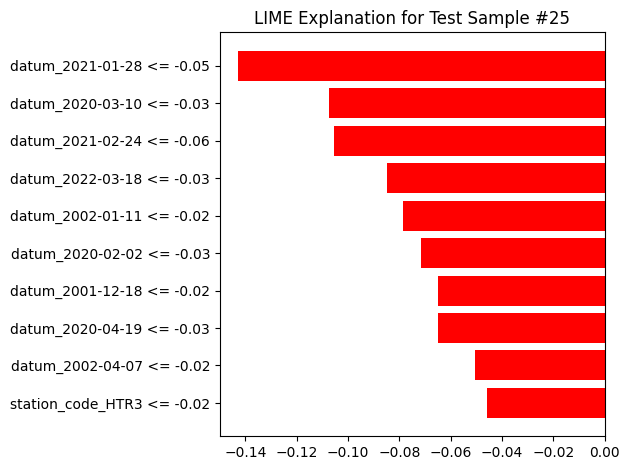


=== Explanation for Test Sample #100 ===

Feature values for this day:
aspect                      2.0
elevation                2196.0
max_height               189.71
TSS_mod                  -7.779
prop_base_3_diff            0.0
                          ...  
Dataset_Data3_nowcast     False
month_December            False
month_February            False
month_January             False
month_March               False
Name: 8496, Length: 488, dtype: object
True label: No Avalanche


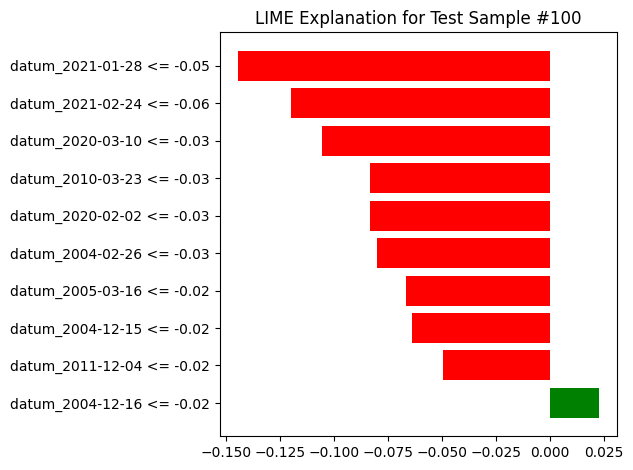

In [17]:
#Do LIME with multiple test indices
#LIME explanations are local → they’re specific to one sample only

# Get indices of a few test examples
example_indices = [0, 5, 25, 100]  # you can change or expand this list

# Loop through and explain each
for i in example_indices:
    print(f"\n=== Explanation for Test Sample #{i} ===")

    # Get corresponding unscaled row (for showing readable values)
    original_features = X_test.iloc[i]
    true_label = y_test.iloc[i]

    # Print real-world feature values for that day
    print("\nFeature values for this day:")
    print(original_features)
    print(f"True label: {'Avalanche' if true_label == 1 else 'No Avalanche'}")

    # LIME explanation
    exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)

    # Show barplot explanation
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for Test Sample #{i}")
    plt.tight_layout()
    plt.show()

# Red bars show features pushing the prediction toward “Avalanche”.
# Green bars show features pushing toward “No Avalanche”.

# Most features were red ("Avalanche"), but the green ones ("No Avalanche") had stronger weights, so the final prediction was "No Avalanche".

#TO DO?
#Apply this to false negatives to understand what went wrong


#=== Explanation for Test Sample #0 ===
# This is one individual day that your Random Forest model was asked to classify: Will an avalanche happen or not?

Feature values for this day:
aspect                      1.0
elevation                2730.0
max_height                47.93
TSS_mod                  -6.265
prop_base_3_diff            0.0
                          ...  
Dataset_Data3_nowcast      True
month_December            False
month_February            False
month_January              True
month_March               False
#Actual values used by the model to make the prediction for this day.

#Name: 11157, Length: 488, dtype: object
#True label: No Avalanche #The truth (real label) for this day is 0 = No Avalanche
    
#PROBLEM:
#Datum_... are being treated as features, which is why LIME is using them
#— but they are not actual physical/meteorological features like temperature, snow height, etc.
#LIME: Model is relying on specific dates, which it shouldn’t ==> it overfits


# SO WE NEED TO?!?!?: 
# Drop datum at the beginning

#GOAL
#Avoid polluting your model with date-specific variables
#Make LIME and RF focus on actual environmental conditions
#Improve generalization across winters and stations

# LIMITATIONS:

1) Imbalanced Classes
Avalanche days are rare → models tend to favor the majority class

You tackled this well by evaluating recall, not just accuracy.

Consider also: class_weight='balanced' in your classifier

Upsampling avalanche days (SMOTE, etc.)

2) No Temporal Component
You treat each day as independent.

In reality, snowpack conditions evolve — so time-series models (like LSTMs) could perform better.

3) LIME is Local
LIME only explains one instance at a time.

It’s useful for individual decision-making, but doesn’t show global model behavior.

For global insights, SHAP is more robust.

4) No Uncertainty Estimates
Your model gives probabilities, but no confidence intervals.